This document provides the EWA score calculations

In [1]:
# Load data and libraries

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
player_DF = pd.read_pickle('data_all_TSE')
player_info = pd.read_pickle('info_all_TSE') 

In [2]:
# Just a quick check
print(player_DF.head())
print(player_info.head())

  playerid round gameid    payoff globalid                strats  \
0       26     1      1  0.100000       15  [0.0, 0.0, 0.0, 1.0]   
1       26     2      1  7.813333       15  [0.0, 0.5, 0.5, 0.0]   
2       26     3      1  7.250000       15  [0.0, 0.0, 1.0, 0.0]   
3       26     4      1  8.231944       15  [0.0, 0.5, 0.5, 0.0]   
4       26     5      1  9.366667       15  [0.0, 0.0, 1.0, 0.0]   

                   self_avg_s  \
0  [0.146, 0.306, 0.248, 0.3]   
1     [0.13, 0.61, 0.26, 0.0]   
2   [0.075, 0.35, 0.575, 0.0]   
3    [0.18, 0.38, 0.42, 0.02]   
4     [0.23, 0.3, 0.42, 0.05]   

                                      opponent_avg_s  \
0  [0.15, 0.38722222222222225, 0.4461111111111111...   
1  [0.16666666666666666, 0.39666666666666667, 0.3...   
2  [0.225, 0.3333333333333333, 0.325, 0.116666666...   
3  [0.3416666666666667, 0.35555555555555557, 0.30...   
4  [0.13125, 0.33958333333333335, 0.5291666666666...   

                    prev_self  \
0                     

In [3]:
# Calculates payoff given mixed strategy by the vector s, round t

def calc_payoff(s_idx, t, player_info, player_DF):
    nr = player_info.n_strats
    self_s = np.zeros(nr)
    self_s[s_idx] = 1
    opp_s = np.array(player_DF['opponent_avg_s'][player_DF['round']==t].values[0])
    mat = player_info['payoff_mat']
    return np.dot(np.dot(self_s,mat),opp_s.T)

In [4]:
# The attention function

def delta(t, s_idx, player_info, player_DF):
    val = player_DF.payoff[player_DF['round']==t]
    if calc_payoff(s_idx,t, player_info, player_DF)>=float(val):
        δ=1
    else:
        δ=0
    return δ

In [5]:
# The change-dectecting decay rate

def phi_rate(t, player_info, player_DF):
    S_t=0
    for m in range(0,len(player_DF.opponent_avg_s.iloc[0])):
        h_t = [sum(i) for i in zip(*player_DF.opponent_avg_s[player_DF['round']<=t])][m]/len(player_DF['round'][player_DF['round']<=t])
        r_t=player_DF.opponent_avg_s[player_DF['round']==t].values[0][m]
        S_t += (h_t-r_t)**2
    return 1-S_t/2

In [6]:
# Calculate attractions and experience weights

def calc_attraction(s_idx, t, player_info, player_DF, para, N_prev, A_prev = None, endog = False):
    κ = para[0]
    ϕ = para[1]
    δ = para[2]
    λ = para[3]
    if endog==1:
        N = phi_rate( t, player_info, player_DF)  * N_prev + 1
        d_t = delta( t, s_idx, player_info, player_DF)
        A_1 = phi_rate( t, player_info, player_DF) * N_prev * A_prev
        A_2 = ( d_t + ( 1 - d_t )*player_DF['strats'].loc[player_DF['round']==t].iloc[0][s_idx] ) * calc_payoff(s_idx, t, player_info, player_DF) 
        A = ( A_1 + A_2 ) / N
    else:
        N = ϕ *( 1 - κ ) * N_prev + 1
        A = ϕ * N_prev * A_prev + ( δ + (1-δ)*player_DF['strats'].loc[player_DF['round']==t].iloc[0][s_idx]) * calc_payoff(s_idx, t, player_info, player_DF)
        A = A / N
    return [A, N]

In [7]:
# Add attractions A[t] to dataframe

def add_Ats_to_DF(player_info, player_DF, para, endog = False):
    nr = player_info.n_strats.iloc[0]
    A = [np.ones(nr) / nr]
    N = [1]
    for t in player_DF['round'].iloc[:-1]:
        As = np.ones(nr)
        for s in range(0, nr):   
            As[s] = calc_attraction( s, t, player_info.iloc[0], player_DF, para, N[-1], A[-1][s], endog)[0]
        A.append(As)
        N.append(calc_attraction( 0, t, player_info.iloc[0], player_DF, para, N[-1], A[-1][0], endog)[1])
    return N, A

In [8]:
#Logits

def add_logits_to_DF(player_info, player_DF, λ):
    Out = []
    nr = player_info.n_strats.iloc[0]
    for t in range(0,len(player_DF['round'].unique())):
        As = player_DF['A'].iloc[t]
        tot_log = 0
        vec = np.zeros(nr)
        for s in range(0, nr):
            if np.exp(λ*As[s]) > 10**30:
                vec[s] = 10**30
                vec[s].astype(np.longdouble)
            else:
                vec[s] = np.exp(λ*As[s]).astype(np.longdouble)
            tot_log += vec[s]
        Out.append(vec/tot_log)
    return Out

In [9]:
#get average distance for all players

def calc_tot_distance(sessions, games, para, endog = False):
    dist = 0
    for sid in sessions:
        for gid in games:
            for pid in player_DF.playerid[(player_DF['gameid']==gid) & (player_DF['session']==sid)].unique():
                DF_t = player_DF[(player_DF['gameid']==gid) & (player_DF['playerid']==pid) & (player_DF['session']==sid)]
                info_t = player_info[(player_info['gameid']==gid) & (player_info['playerid']==pid) & (player_info['session']==sid)]
                DF_t['N'] = add_Ats_to_DF( info_t, DF_t, para, endog)[0]
                DF_t['A'] = add_Ats_to_DF( info_t, DF_t, para, endog)[1]
                DF_t['log_probs'] = add_logits_to_DF(info_t, DF_t, para[3])
                dist += np.sum(np.sum((DF_t['strats']-DF_t['log_probs'])**2))
    return dist

In [10]:
#Simple test

para = [0,0,1,1]
calc_tot_distance([1],[1], [1,1,0,0.6333460187277263], 0)

221.2957111577059

In [81]:
# Generate a min function for different parameter combinations
# λ free, δ=1, ϕ =κ=0 qantal response cournot 

def max_func(sessions, games, λ):
    para = [0,0,1,λ]  
    return calc_tot_distance(sessions, games, para, 0)

In [85]:
# δ=1, κ=0, λ and ϕ free weighted stochastic fictious play 

def max_func(sessions, games, par):
    λ = par[0]
    ϕ = par[1]
    para = [0,ϕ,1,λ]  
    return calc_tot_distance(sessions, games, para, 0)

In [89]:
# λ and ϕ free, δ=0 and κ=1 is comulative reinforcement model

def max_func(sessions, games, par):
    λ = par[0]
    ϕ = par[1]
    para = [1,ϕ,0,λ]  
    return calc_tot_distance(sessions, games, para, 0)

In [15]:
# self-tuning EWA (endog=1)

def max_func(sessions, games, λ):
    para = [0,0,1,λ]  
    return calc_tot_distance(sessions, games, para, 1)

In [12]:
# All free EWA full power

def max_func(sessions, games, par):
    return calc_tot_distance(sessions, games, par, 0)

In [12]:
# Calc distance for benchmarks
def calc_tot_dist_bench(sessions, games, mix=1):
    dist = 0
    for sid in sessions:
        for gid in games:
            for pid in player_DF.playerid[(player_DF['gameid']==gid) & (player_DF['session']==sid)].unique():
                DF_t = player_DF[(player_DF['gameid']==gid) & (player_DF['playerid']==pid) & (player_DF['session']==sid)]
                info_t = player_info[(player_info['gameid']==gid) & (player_info['playerid']==pid) & (player_info['session']==sid)]
                if mix==1:
                    mix_b = np.ones(info_t.n_strats.iloc[0])/info_t.n_strats.iloc[0]
                    dist += np.sum(np.sum((DF_t['strats'].reset_index(drop=True)-pd.Series([mix_b]*len(DF_t['strats'])))**2))
                elif mix==2:
                    ownpp = pd.Series([np.ones(info_t.n_strats.iloc[0])/info_t.n_strats.iloc[0]])
                    ownpp = pd.concat([ownpp, DF_t['strats'].reset_index(drop=True)[:-1]], axis=0)
                    dist += np.sum(np.sum((DF_t['strats'].reset_index(drop=True).apply(np.array)-ownpp.reset_index(drop=True))**2))
                else:
                    mypop = pd.Series([np.ones(info_t.n_strats.iloc[0])/info_t.n_strats.iloc[0]])
                    mypop = pd.concat([mypop, DF_t['self_avg_s'].reset_index(drop=True)[:-1]], axis=0)
                    dist += np.sum(np.sum((DF_t['strats'].reset_index(drop=True).apply(np.array)-mypop.reset_index(drop=True))**2))
    return dist

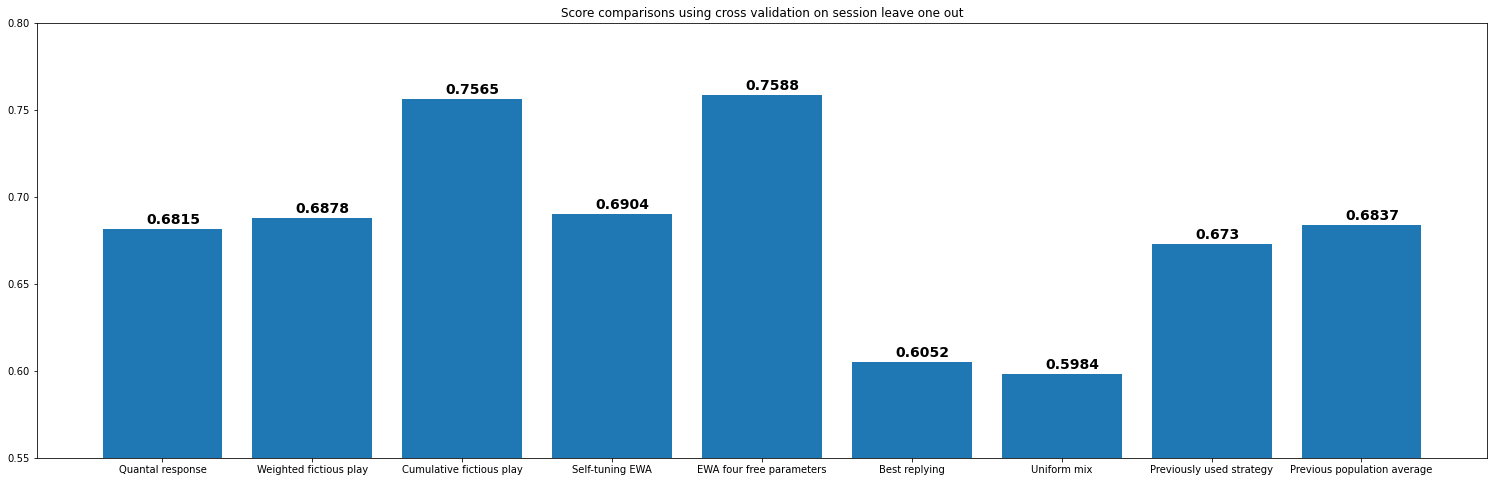

In [135]:
# Bar plot of scores - cross valdidation session level for all games
data = pd.read_pickle('data/score_ses')
data_bench = pd.read_pickle('data/benchmark_ses_game').sum(axis=1)
data= pd.concat([data,data_bench], axis = 0).reset_index(drop=True)
data = np.round(1- data.values/len(player_DF),4).ravel()
labels = ['Quantal response', 'Weighted fictious play', 'Cumulative fictious play' , 'Self-tuning EWA', 'EWA four free parameters', 
          'Best replying', 'Uniform mix', 'Previously used strategy', 'Previous population average']
fig, ax = plt.subplots( figsize=(26, 8))
ax.bar(labels, data.tolist())
ax.set_ylim([0.55, 0.8])
ax.set_title("Score comparisons using cross validation on session leave one out")
for i, v in enumerate(data):
    ax.text( i-0.11 ,v+0.003, str(v), color='black', fontweight='bold', fontsize=14)
    
plt.savefig('cross_score_ses.png')

In [134]:
# Cross validation session and game

qr_dist = []
wsfp_dist = []
crfm_dist = []
st_ewa_dist = []
f_ewa_dist = []

for gid in player_DF.gameid.unique()-1:
    qr_dist_game = 0
    wsfp_dist_game = 0
    crfm_dist_game = 0
    st_ewa_dist_game = 0
    f_ewa_dist_game = 0
    for sid in np.arange(0,7):
        qr_para = [0,0,1,pd.read_pickle('data/para_model_by_game').iloc[gid,0][sid].x[0]]
        wsfp_para = [0,pd.read_pickle('data/para_model_by_game').iloc[gid,1][sid].x[1],1,
                     pd.read_pickle('data/para_model_by_game').iloc[gid,1][sid].x[0]]
        crfm_para = [1,pd.read_pickle('data/para_model_by_game').iloc[gid,2][sid].x[1],0,
                     pd.read_pickle('data/para_model_by_game').iloc[gid,2][sid].x[0]]
        st_ewa_para = [0,0,0,pd.read_pickle('data/para_model_by_game').iloc[gid,3][sid].x[0]]
        f_ewa_para = pd.read_pickle('data/para_model_by_game').iloc[gid,4][sid].x.tolist()


        qr_dist_game += calc_tot_distance([sid], [gid+1], qr_para, 0)
        wsfp_dist_game += calc_tot_distance([sid], [gid+1], wsfp_para, 0)
        crfm_dist_game += calc_tot_distance([sid], [gid+1], crfm_para, 0)
        st_ewa_dist_game += calc_tot_distance([sid], [gid+1], st_ewa_para, 1)
        f_ewa_dist_game += calc_tot_distance([sid], [gid+1], f_ewa_para, 0)

    qr_dist.append(qr_dist_game)
    wsfp_dist.append(wsfp_dist_game)
    crfm_dist.append(crfm_dist_game)
    st_ewa_dist.append(st_ewa_dist_game)
    f_ewa_dist.append(f_ewa_dist_game)

out = pd.DataFrame([qr_dist, wsfp_dist, crfm_dist, st_ewa_dist, f_ewa_dist])
out.to_pickle(f"data/score_gses")    

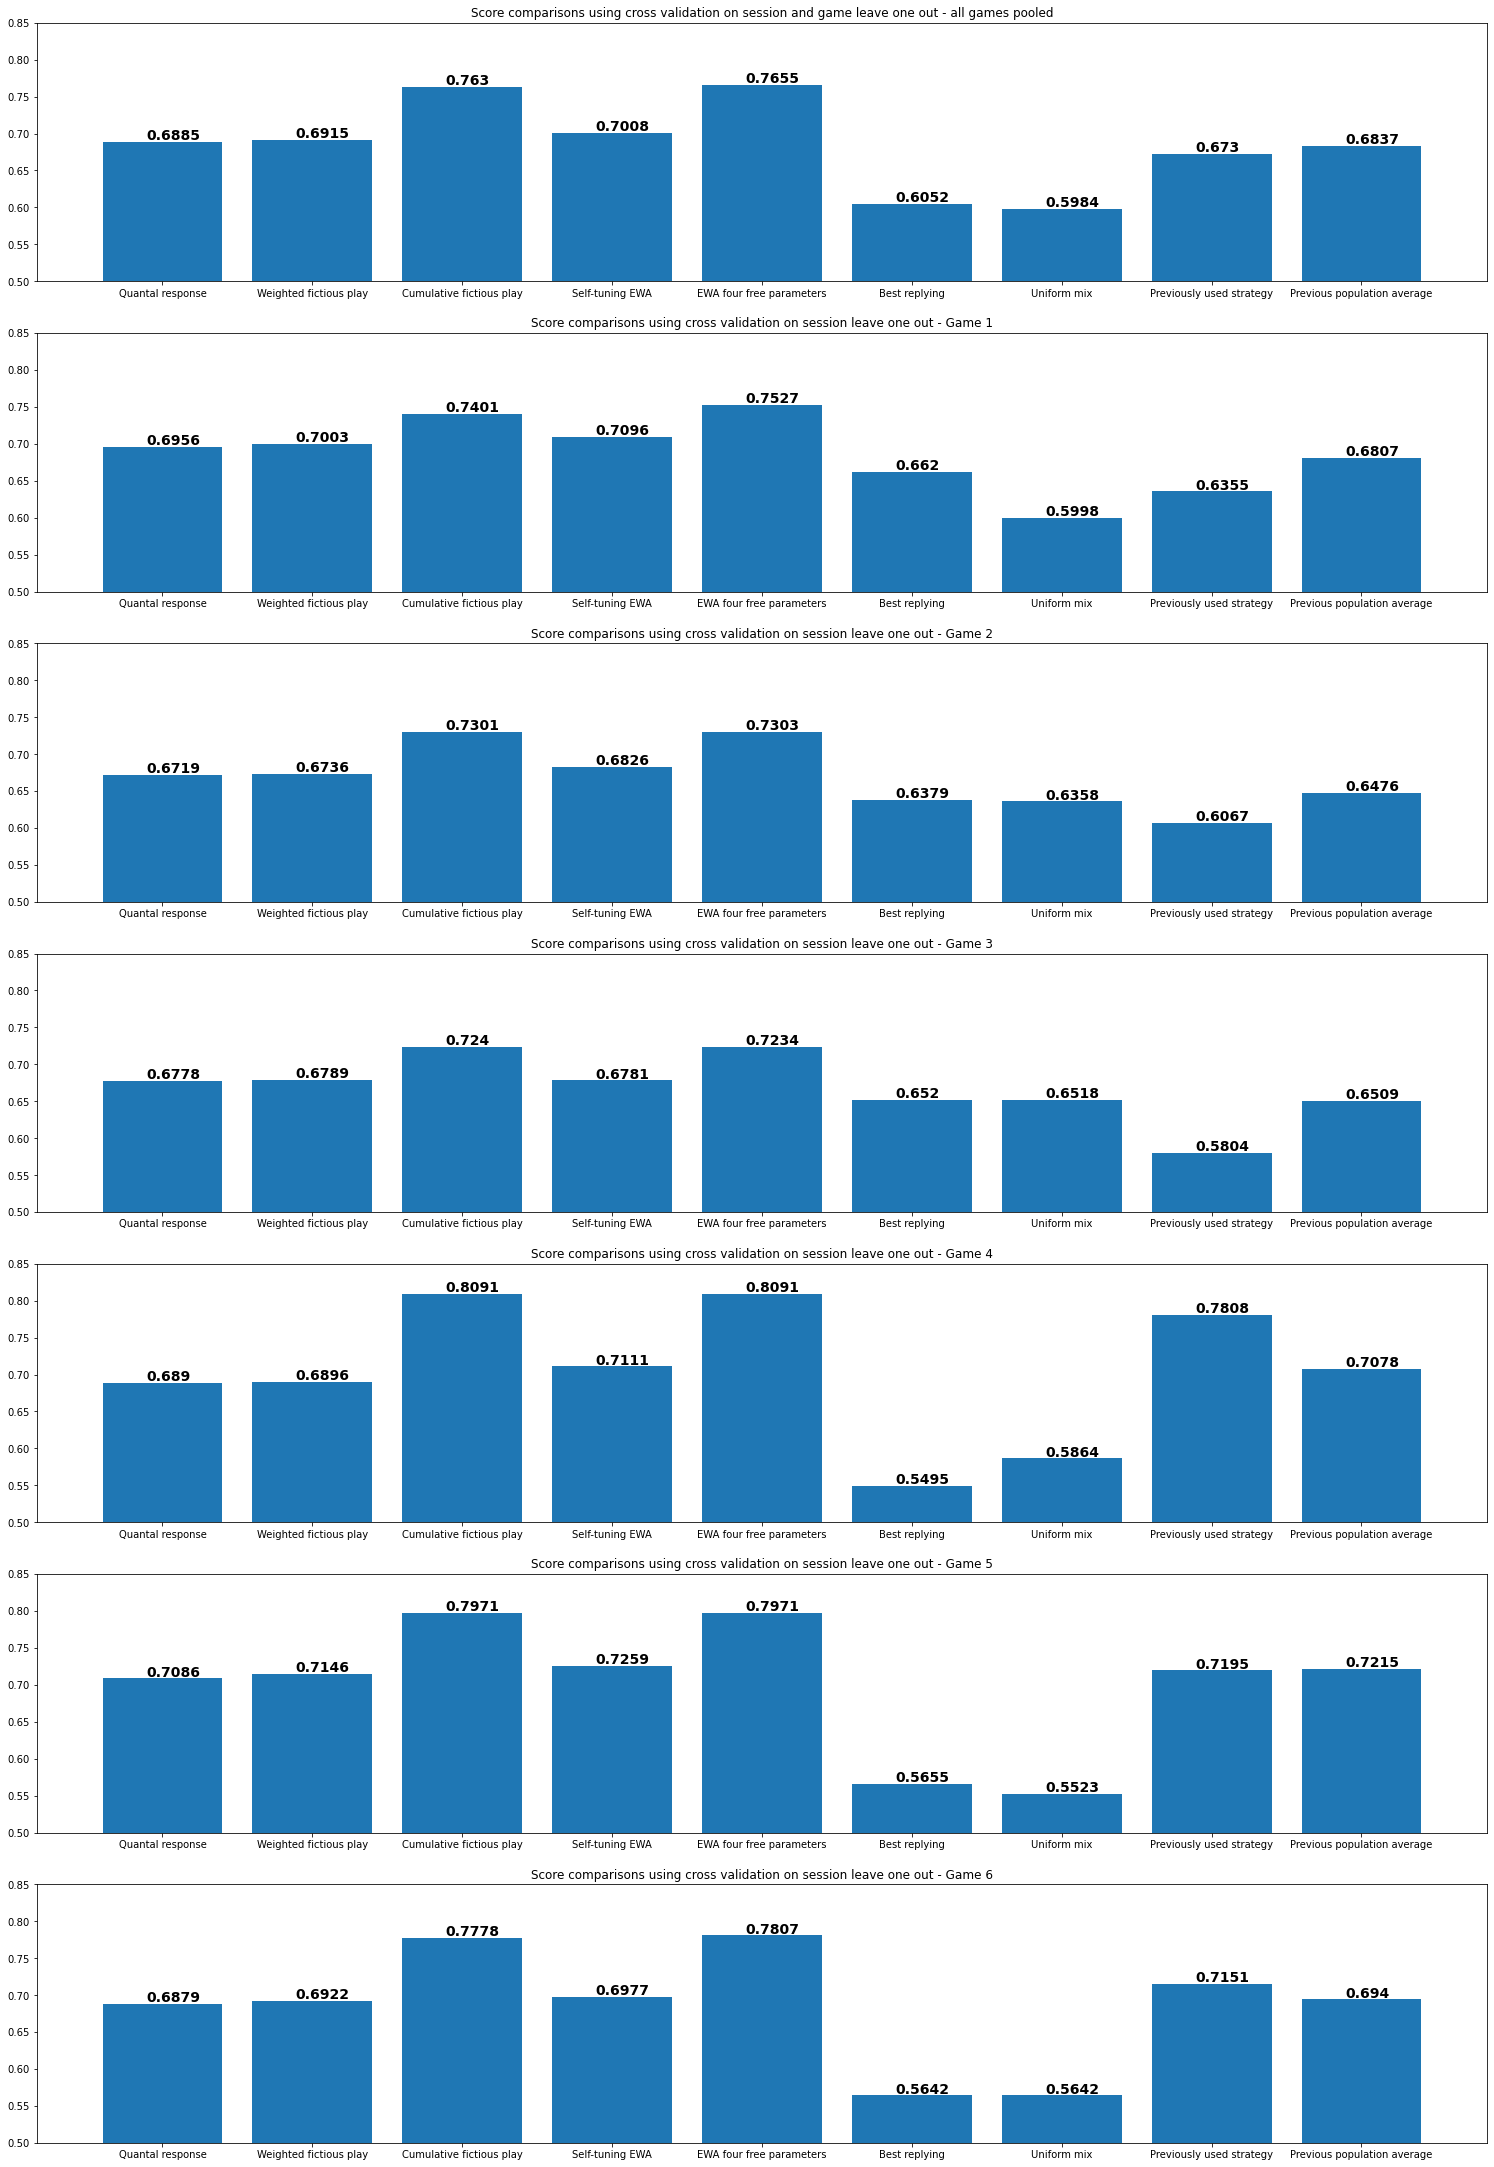

In [139]:
# Bar plot of scores - cross valdidation session level per game
inn = pd.read_pickle('data/score_gses')
inn_bench = pd.read_pickle('data/benchmark_ses_game')
data = pd.concat([inn,inn_bench], axis = 0).reset_index(drop=True)
data_game = []

labels = ['Quantal response', 'Weighted fictious play', 'Cumulative fictious play' , 'Self-tuning EWA', 'EWA four free parameters', 
          'Best replying', 'Uniform mix', 'Previously used strategy', 'Previous population average']

fig, ax = plt.subplots(7,1, figsize=(26, 39))

for gid in np.arange(0,7):
    if gid==0:
        ax[gid].set_title("Score comparisons using cross validation on session and game leave one out - all games pooled")
        data_game.append(np.round(1- np.sum(data.values, axis=1)/len(player_DF),4) )
    else:
        ax[gid].set_title(f"Score comparisons using cross validation on session leave one out - Game {gid}")
        data_game.append(np.round(1-data[gid-1].values/len(player_DF[player_DF.gameid==gid]),4))
    
    ax[gid].bar(labels, data_game[gid])
    ax[gid].set_ylim([0.5, 0.85])
    for i, v in enumerate(data_game[gid]):
        ax[gid].text( i-0.11 ,v+0.003, str(v), color='black', fontweight='bold', fontsize=14)

plt.savefig('cross_score_gses.png')